In [1]:
import torch
import torch.nn.functional as F
from torch import nn, optim

from geomloss import SamplesLoss

import numpy as np
import pandas as pd

import sklearn.preprocessing, sklearn.decomposition
import umap

from collections import Counter
from types import SimpleNamespace

import joblib
import json
import os
import random
import sys

In [2]:
sys.path.append("../../src")

%reload_ext autoreload
#%load_ext autoreload
%autoreload 2

import train as this
import klein as kl

import annoy

sys.path.append("..")
import spring_helper as sh

In [3]:
from tqdm.notebook import tqdm

In [4]:
import scipy.sparse
import sklearn
import umap

import numpy as np
import pandas as pd

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocess dataset

## Raw data

In [6]:
expr = sh.load_npz("/data/gl/g2/sachit/data/klein/processed/counts_matrix_in_vitro.npz")
genes = sh.load_genes("/data/gl/g2/sachit/data/klein/processed/gene_names_in_vitro.txt")
highly_variable_genes = sh.filter_genes(expr)
cell_cycle_genes = [['Ube2c',
                    'Hmgb2',
                    'Hmgn2',
                    'Tuba1b', 
                    'Ccnb1', 
                    'Tubb5', 
                    'Top2a', 
                    'Tubb4b']]
non_cell_cycle_idx = sh.remove_corr_genes(expr, gene_list=genes, exclude_corr_genes_list=cell_cycle_genes, test_gene_idx=highly_variable_genes, min_corr=0.1)
non_cell_cycle_idx = non_cell_cycle_idx[0:2447]
# perform filtering
expr = expr[:, non_cell_cycle_idx]

use_genes = [genes[i] for i in non_cell_cycle_idx]

In [7]:
meta = pd.read_csv("/data/gl/g2/sachit/data/klein/spring/in_vitro/metadata.csv")
meta = meta.drop(meta.columns[0], axis = 1)
meta.head()

,Time point,Population,Annotation,Well,numeric_annotation
0,6.0,LK,undiff,2,1
1,6.0,LK,undiff,2,1
2,6.0,LK,Monocyte,2,2
3,6.0,LK,Neutrophil,2,3
4,6.0,LK,undiff,2,1


In [8]:
x = expr.todense()

Since we are holding out the middle time point, we will not use it for fitting the data transformation

In [9]:
y = meta['Time point'].values.astype(int)

In [10]:
ix_tr = meta['Time point'] != 4
ix_te = meta['Time point'] == 4

x_tr = x[ix_tr]
x_te = x[ix_te]
y_tr = y[ix_tr]
y_te = y[ix_te]

meta_tr = meta.loc[ix_tr]
meta_te = meta.loc[ix_te]

In [11]:
scaler = sklearn.preprocessing.StandardScaler()
pca = sklearn.decomposition.PCA(n_components = 50)
um = umap.UMAP(n_components = 2, metric = 'euclidean', n_neighbors = 30)

In [12]:
x_tr = scaler.fit_transform(x_tr)
xp_tr = pca.fit_transform(x_tr)
xu_tr = um.fit_transform(xp_tr) 

x_te = scaler.transform(x_te)
xp_te = pca.transform(x_te)
xu_te = um.transform(xp_te)

Plot annotated cell types

In [13]:
annot_order = list(meta_tr['Annotation'].value_counts().sort_values(ascending = False).index)
annot_order

['undiff',
 'Neutrophil',
 'Monocyte',
 'Baso',
 'Mast',
 'Meg',
 'Erythroid',
 'Eos',
 'Lymphoid',
 'Ccr7_DC',
 'pDC']

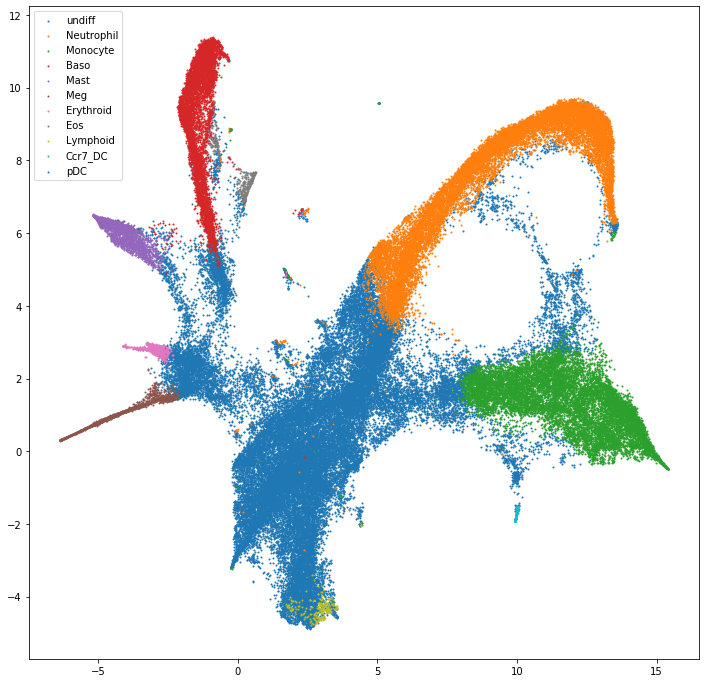

In [14]:
fig, ax = plt.subplots(figsize = (12, 12))
for a in annot_order: 
    px = meta_tr['Annotation'] == a
    ax.scatter(xu_tr[px, 0], xu_tr[px, 1], s = 1, label = a)
ax.legend()

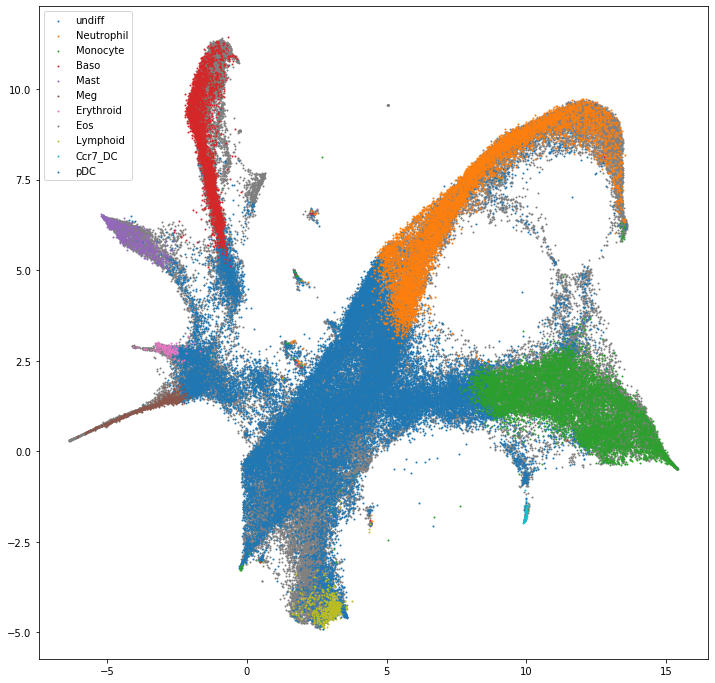

In [15]:
fig, ax = plt.subplots(figsize = (12, 12))
ax.scatter(xu_tr[:,0], xu_tr[:,1], s = 1, color = 'gray')

for a in annot_order:
    px = meta_te['Annotation'] == a
    ax.scatter(xu_te[px, 0], xu_te[px, 1], s = 1, label = a)
ax.legend()

Plot densities at each point

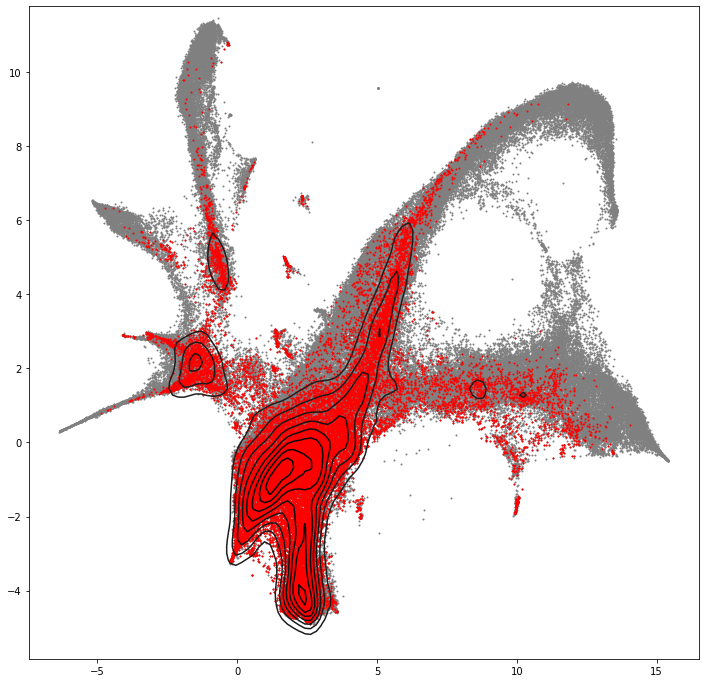

In [16]:
fig, ax = plt.subplots(figsize = (12, 12))
ax.scatter(xu_tr[:,0], xu_tr[:,1], s = 1, color = 'gray')
ax.scatter(xu_te[:,0], xu_te[:,1], s = 1, color = 'gray')

px = y_tr == 2
ax.scatter(xu_tr[px,0], xu_tr[px, 1], color = 'red', s = 1)
sns.kdeplot(xu_tr[px,0], xu_tr[px, 1], color = 'k')

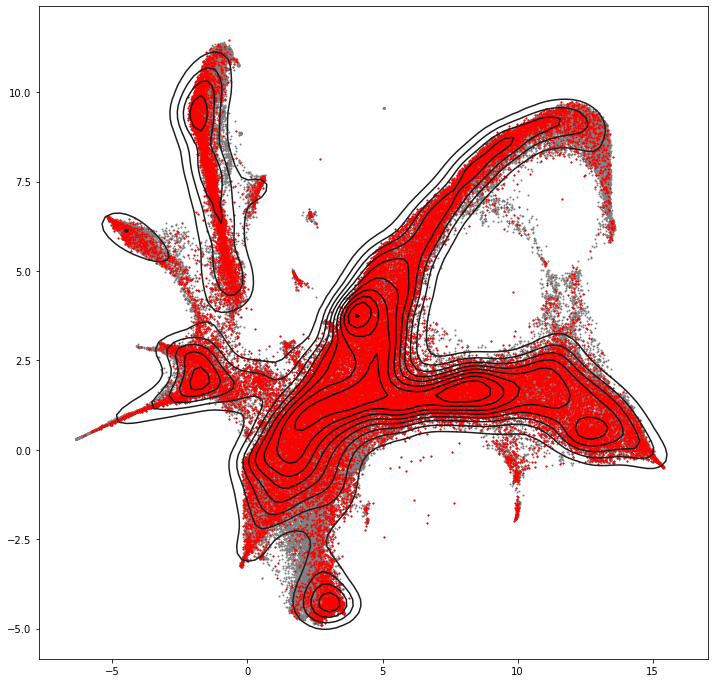

In [17]:
fig, ax = plt.subplots(figsize = (12, 12))
ax.scatter(xu_tr[:,0], xu_tr[:,1], s = 1, color = 'gray')
ax.scatter(xu_te[:,0], xu_te[:,1], s = 1, color = 'gray')

px = y_te == 4
ax.scatter(xu_te[px,0], xu_te[px, 1], color = 'red', s = 1)
sns.kdeplot(xu_te[px,0], xu_te[px, 1], color = 'k')

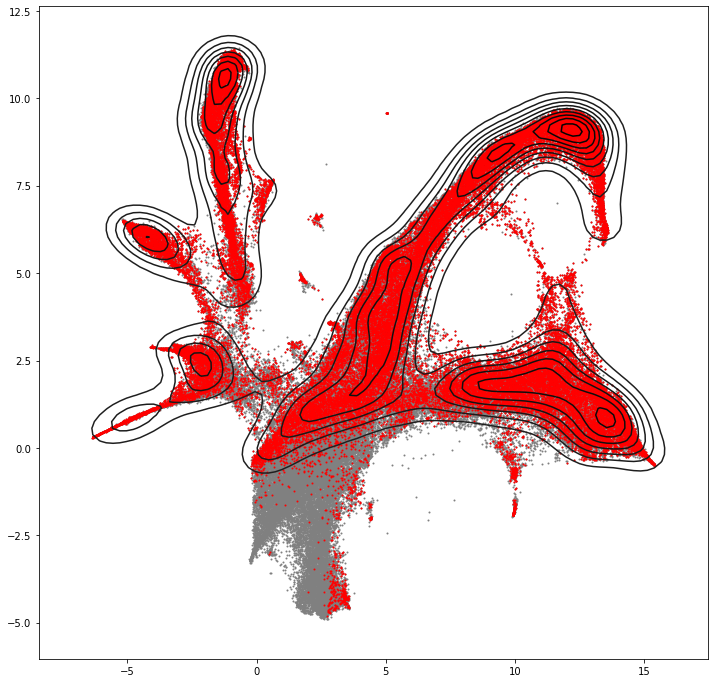

In [18]:
fig, ax = plt.subplots(figsize = (12, 12))
ax.scatter(xu_tr[:,0], xu_tr[:,1], s = 1, color = 'gray')
ax.scatter(xu_te[:,0], xu_te[:,1], s = 1, color = 'gray')

px = y_tr == 6
ax.scatter(xu_tr[px,0], xu_tr[px, 1], color = 'red', s = 1)
sns.kdeplot(xu_tr[px,0], xu_tr[px, 1], color = 'k')

In [19]:
x_l = [x_tr[y_tr == 2,], x_te[y_te == 4,], x_tr[y_tr == 6,]]
xp_l = [xp_tr[y_tr == 2,], xp_te[y_te == 4,], xp_tr[y_tr == 6,]]
xu_l = [xu_tr[y_tr == 2,], xu_te[y_te == 4,], xu_tr[y_tr == 6,]]

x_l = [torch.from_numpy(a).float() for a in x_l]
xp_l = [torch.from_numpy(a).float() for a in xp_l]
xu_l = [torch.from_numpy(a).float() for a in xu_l]

In [22]:
torch.save({
    'meta': meta, 
    'x': x_l, 
    'xp': xp_l, 
    'xu': xu_l, 
    'y': [2, 4, 6], 
}, "../../data/Klein2020_impute.pt")